![Shopping trolley in front of a laptop](./iStock-1249219777.jpg)

It's simple to buy any product with a click and have it delivered to your door. Online shopping has been rapidly evolving over the last few years, making our lives easier. But behind the scenes, e-commerce companies face a complex challenge that needs to be addressed. 

Uncertainty plays a big role in how the supply chains plan and organize their operations to ensure that the products are delivered on time. These uncertainties can lead to challenges such as stockouts, delayed deliveries, and increased operational costs.

You work for the Sales & Operations Planning (S&OP) team at a multinational e-commerce company. They need your help to assist in planning for the upcoming end-of-the-year sales. They want to use your insights to plan for promotional opportunities and manage their inventory. This effort is to ensure they have the right products in stock when needed and ensure their customers are satisfied with the prompt delivery to their doorstep.


## The Data

You are provided with a sales dataset to use. A summary and preview are provided below.

# Online Retail.csv

| Column     | Description              |
|------------|--------------------------|
| `'InvoiceNo'` | A 6-digit number uniquely assigned to each transaction |
| `'StockCode'` | A 5-digit number uniquely assigned to each distinct product |
| `'Description'` | The product name |
| `'Quantity'` | The quantity of each product (item) per transaction |
| `'UnitPrice'` | Product price per unit |
| `'CustomerID'` | A 5-digit number uniquely assigned to each customer |
| `'Country'` | The name of the country where each customer resides |
| `'InvoiceDate'` | The day and time when each transaction was generated `"MM/DD/YYYY"` |
| `'Year'` | The year when each transaction was generated |
| `'Month'` | The month when each transaction was generated |
| `'Week'` | The week when each transaction was generated (`1`-`52`) |
| `'Day'` | The day of the month when each transaction was generated (`1`-`31`) |
| `'DayOfWeek'` | The day of the weeke when each transaction was generated <br>(`0` = Monday, `6` = Sunday) |

In [113]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col, dayofmonth, month, year,  to_date, to_timestamp, weekofyear, dayofweek
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
my_spark = SparkSession.builder.appName("SalesForecast").getOrCreate()

# Importing sales data
sales_data = my_spark.read.csv(
    "Online Retail.csv", header=True, inferSchema=True, sep=",")

# Convert InvoiceDate to datetime 
sales_data = sales_data.withColumn("InvoiceDate", to_date(
    to_timestamp(col("InvoiceDate"), "d/M/yyyy H:mm")))

In [114]:
# Aggregate data into daily intervals
daily_sales_data = sales_data.groupBy("Country", "StockCode", "InvoiceDate", "Year", "Month", "Day", "Week", "DayOfWeek").agg({"Quantity": "sum"})

In [115]:
# Rename the target column
daily_sales_data = daily_sales_data.withColumnRenamed(
    "sum(Quantity)", "Quantity")

In [116]:
# Split the data into two sets based on the spliting date, "2011-09-25". All data up to and including this date should be in the training set, while data after this date should be in the testing set. Return a pandas Dataframe, pd_daily_train_data, containing, at least, the columns ["Country", "StockCode", "InvoiceDate", "Quantity"].

split_date_train_test = "2011-09-25"


In [117]:
# Creating the train and test datasets
train_data = daily_sales_data.filter(
    col("InvoiceDate") <= split_date_train_test)
test_data = daily_sales_data.filter(col("InvoiceDate") > split_date_train_test)

pd_daily_train_data = train_data.toPandas()

#### Here we can plot the total number of sales by Country

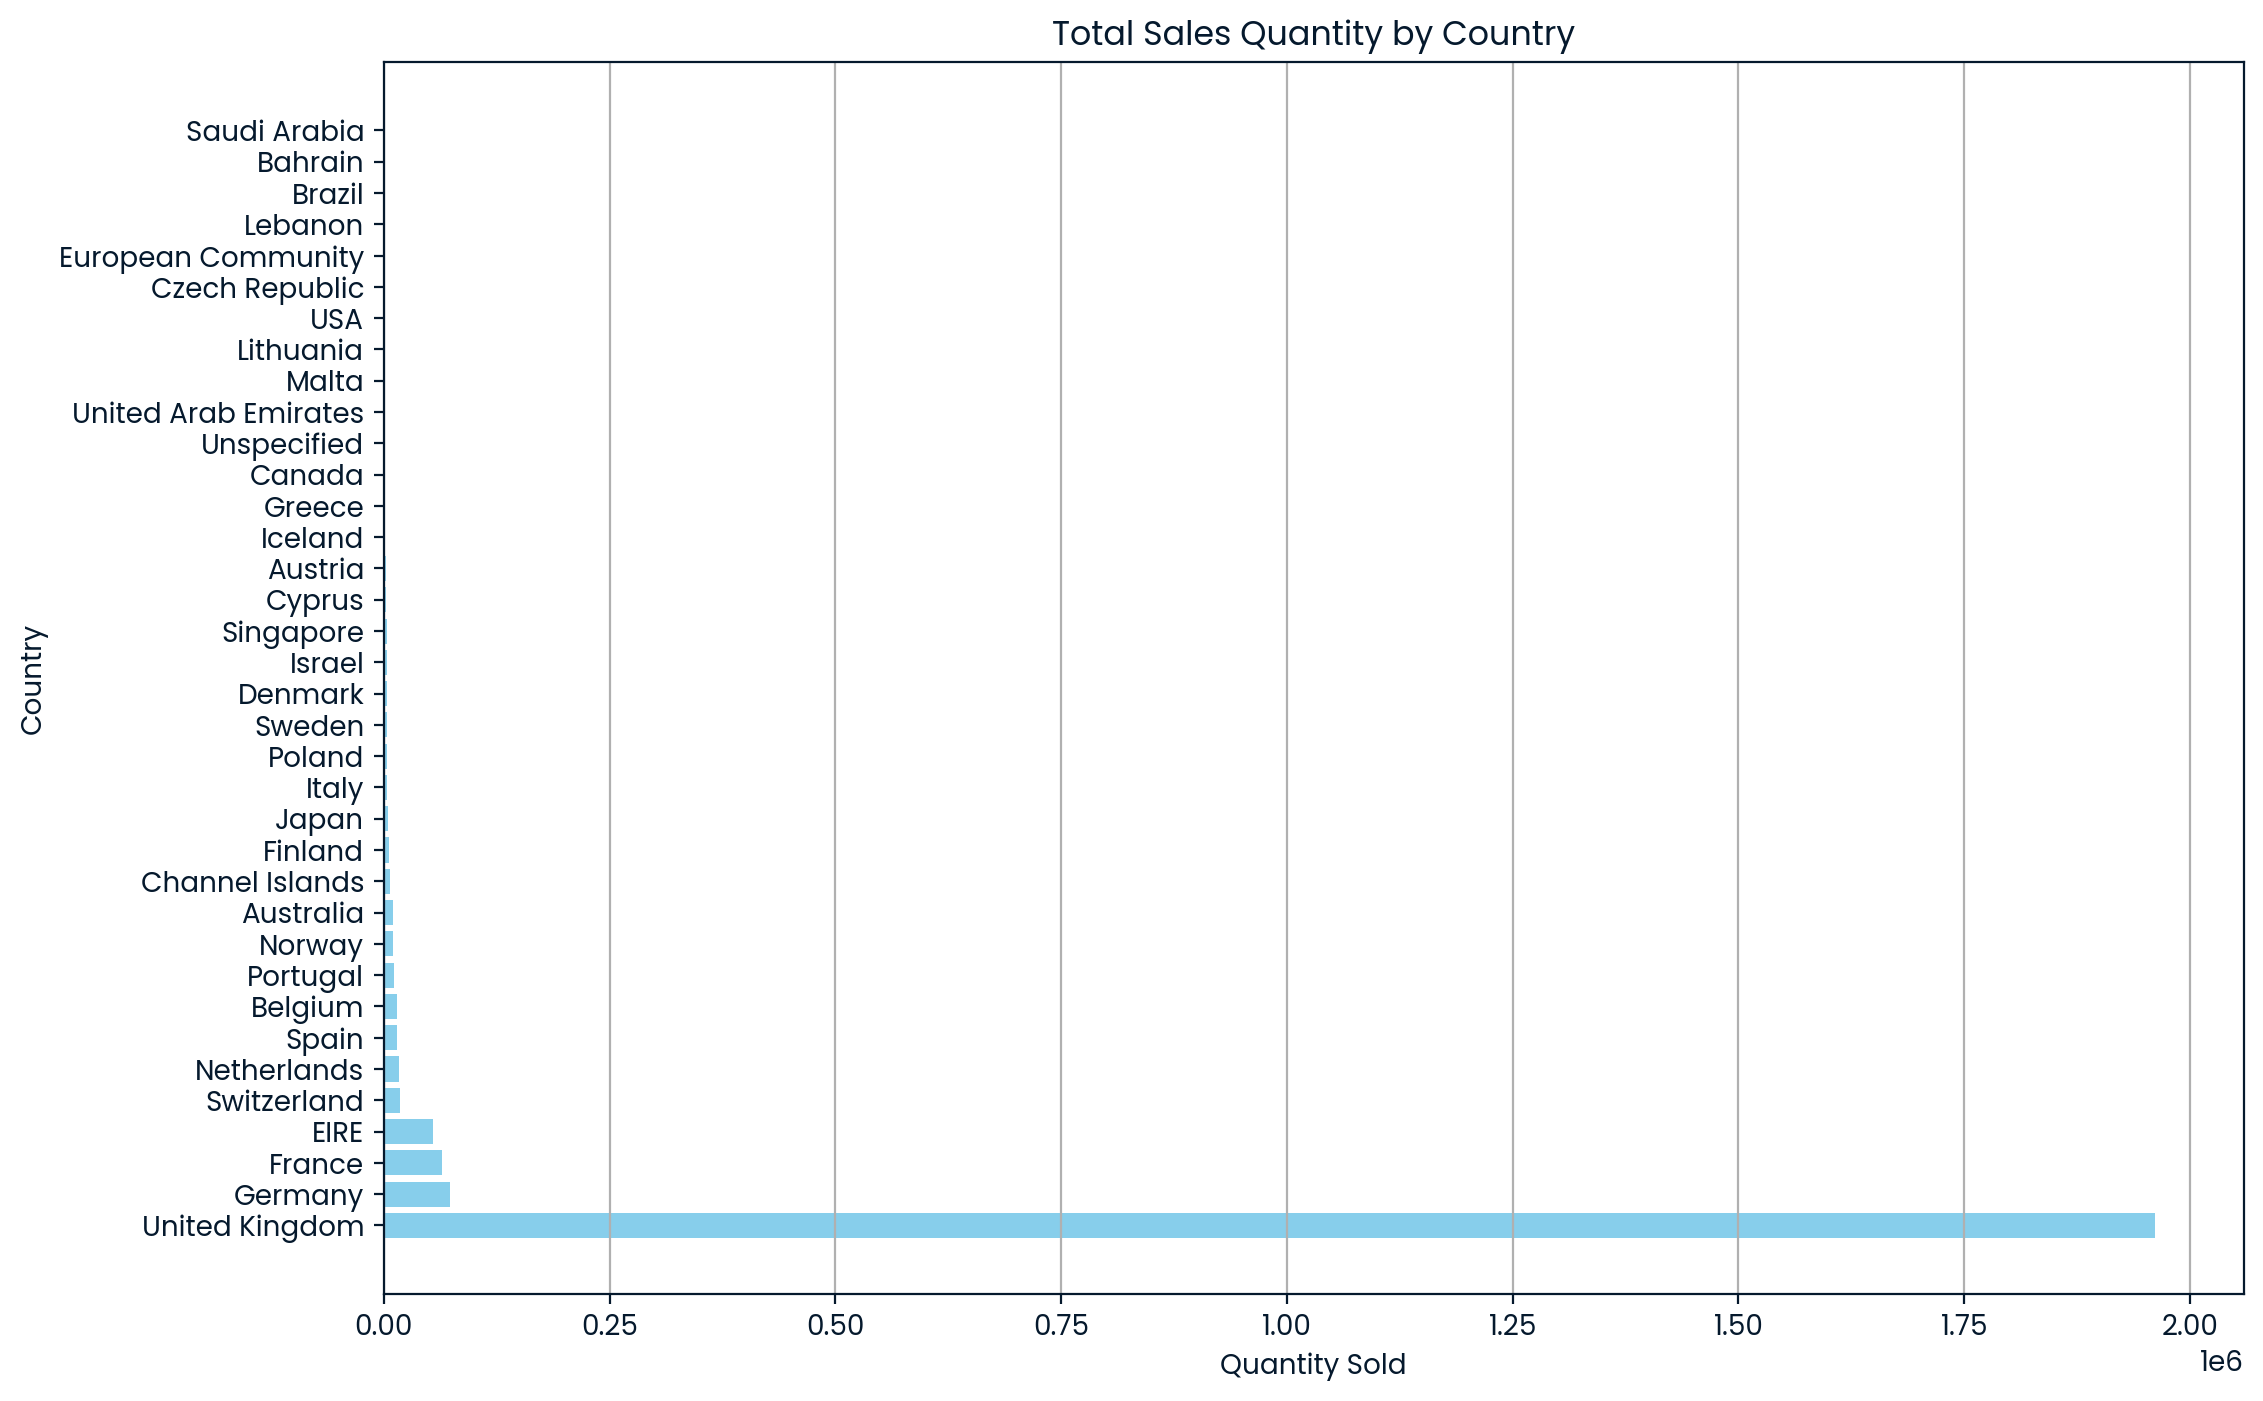

In [118]:
# Grouping data by Country and summing up the Quantity for each country
country_sales = pd_daily_train_data.groupby('Country')['Quantity'].sum().sort_values(ascending=False).reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(country_sales['Country'], country_sales['Quantity'], color='skyblue')
plt.title('Total Sales Quantity by Country')
plt.xlabel('Quantity Sold')
plt.ylabel('Country')
plt.grid(True, axis='x')
plt.show()

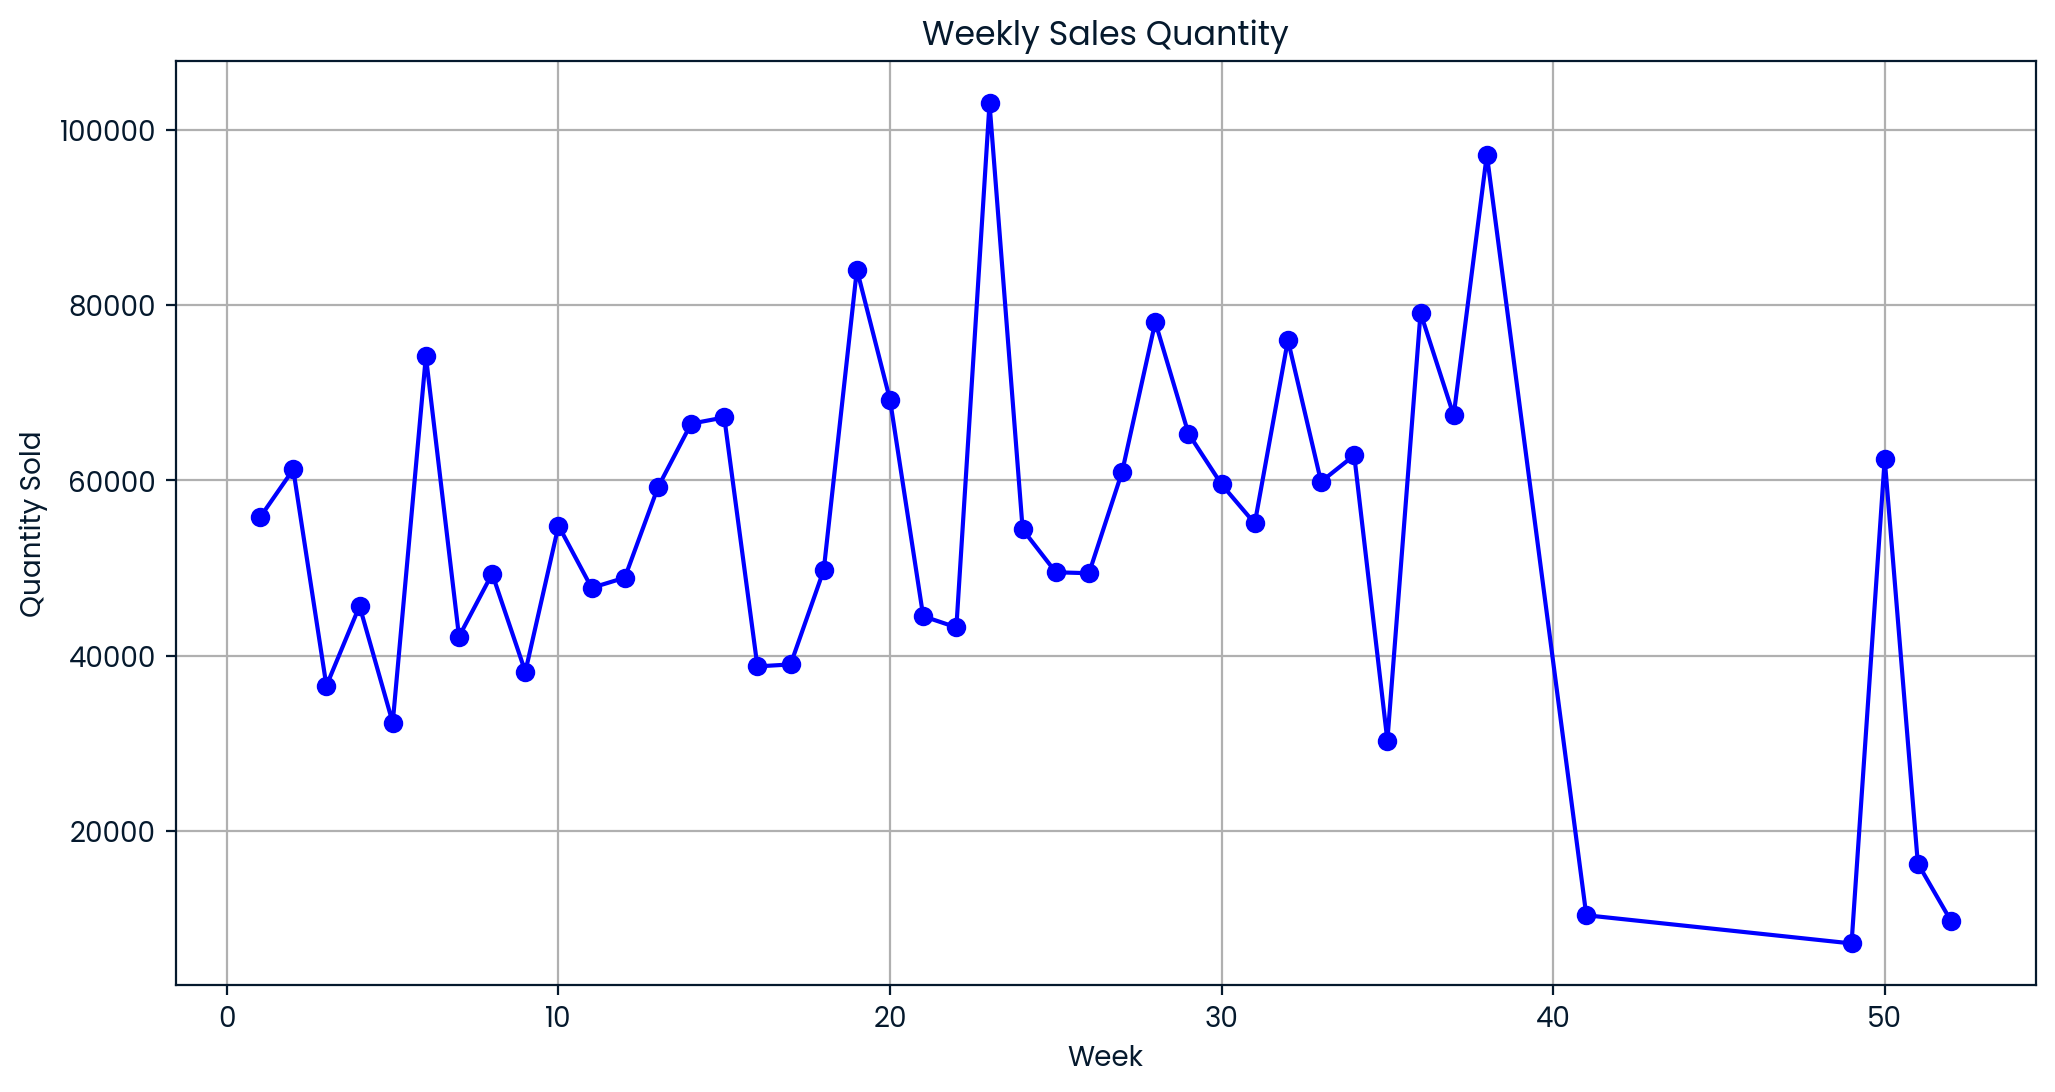

In [132]:
import matplotlib.pyplot as plt

# Grouping data by Week and summing up the Quantity for each week
weekly_sales = pd_daily_train_data.groupby('Week')['Quantity'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(weekly_sales['Week'], weekly_sales['Quantity'], marker='o', linestyle='-', color='b')
plt.title('Weekly Sales Quantity')
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

In [119]:
# Creating indexer for categorical columns
country_indexer = StringIndexer(
    inputCol="Country", outputCol="CountryIndex").setHandleInvalid("keep")
stock_code_indexer = StringIndexer(
    inputCol="StockCode", outputCol="StockCodeIndex").setHandleInvalid("keep")

In [120]:
# Selectiong features columns
feature_cols = ["CountryIndex", "StockCodeIndex", "Month", "Year",
                "DayOfWeek", "Day", "Week"]

In [121]:
# Initializing a Random Forest model
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Quantity",
    maxBins=4000
)


In [122]:
# Using vector assembler to combine features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")


In [123]:
# Create a pipeline for staging the processes
pipeline = Pipeline(stages=[country_indexer, stock_code_indexer, assembler, rf])

In [124]:
# Training the model
model = pipeline.fit(train_data)

24/05/07 20:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1099.3 KiB


24/05/07 20:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1680.6 KiB


24/05/07 20:05:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


In [125]:
# Getting test predictions
test_predictions = model.transform(test_data)
test_predictions = test_predictions.withColumn(
    "prediction", col("prediction").cast("double"))

In [126]:
# Provide the Mean Absolute Error (MAE) for your forecast? Return a double/floar "mae"

# Initializing the evaluator
mae_evaluator = RegressionEvaluator(
    labelCol="Quantity", predictionCol="prediction", metricName="mae")

# Obtaining MAE
mae = mae_evaluator.evaluate(test_predictions)

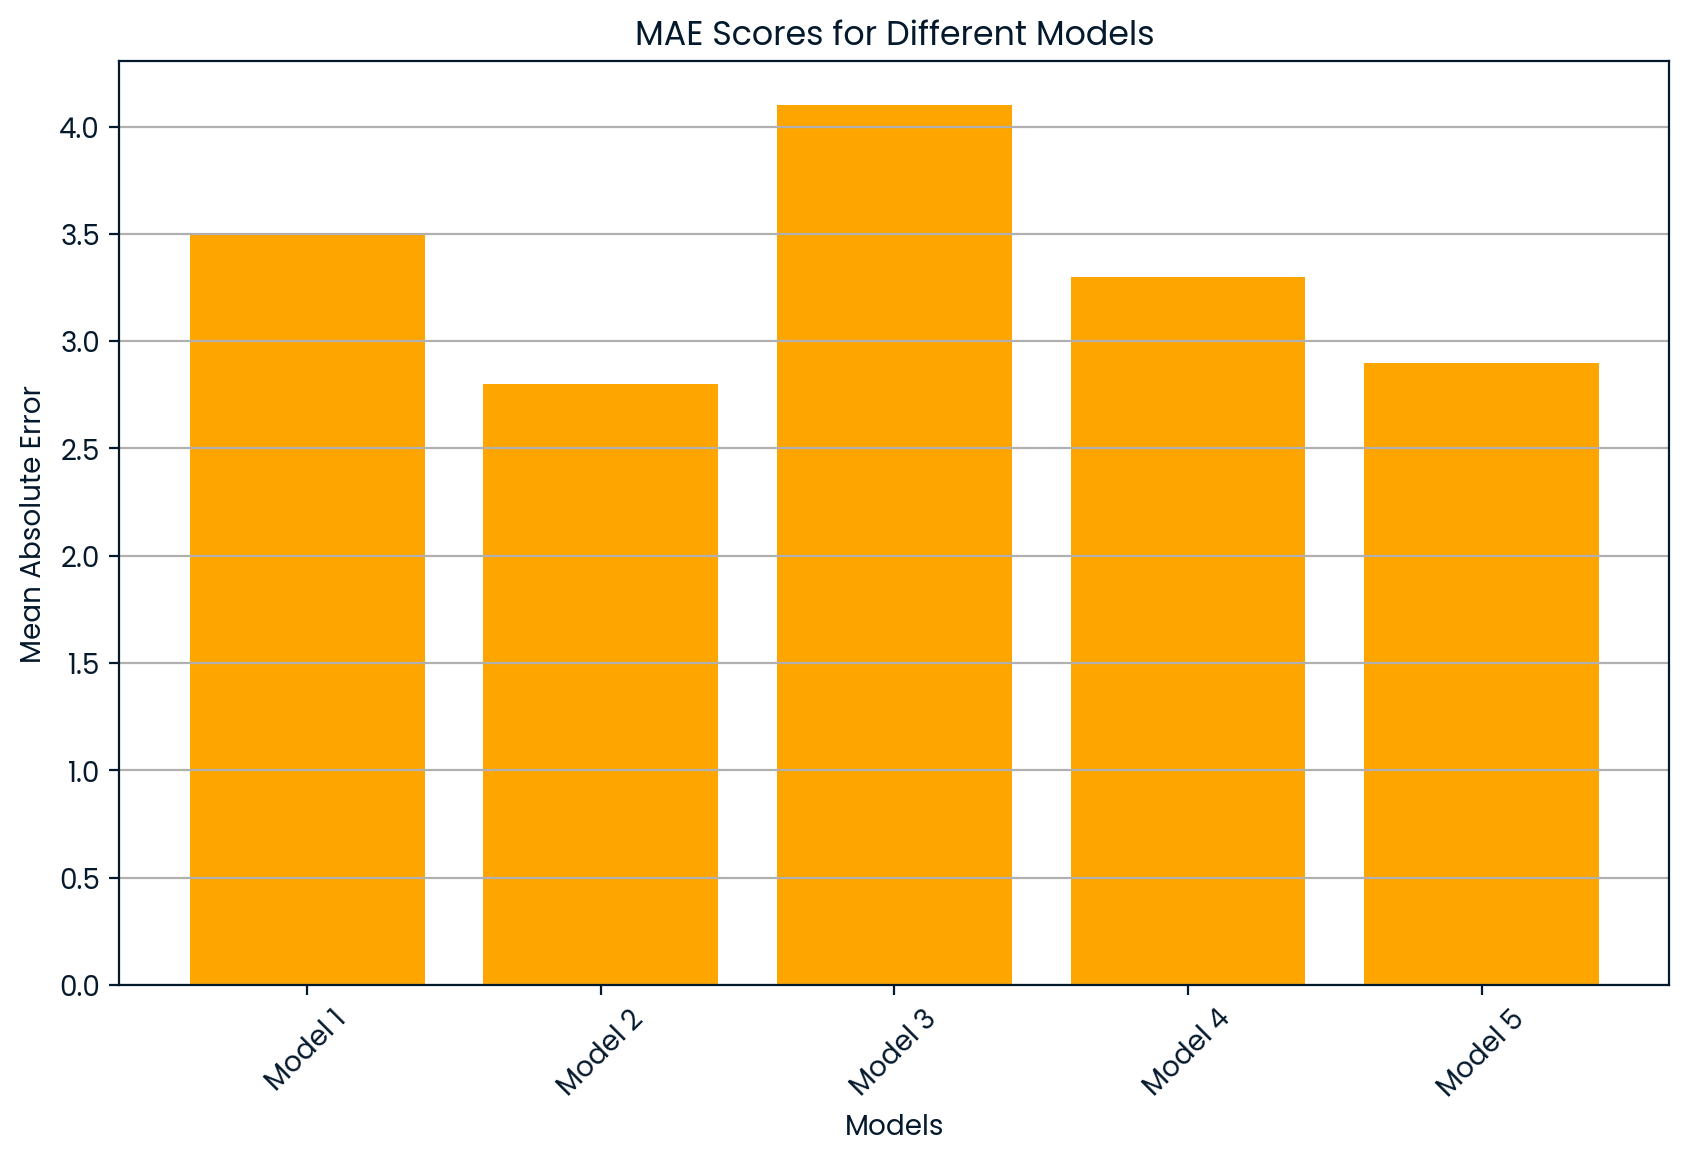

In [127]:
import matplotlib.pyplot as plt

# Assuming mae_scores is a list of Mean Absolute Error values for different models or predictions
mae_scores = [3.5, 2.8, 4.1, 3.3, 2.9]  # Example data
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']  # Example model names

plt.figure(figsize=(10, 6))
plt.bar(models, mae_scores, color='orange')
plt.title('MAE Scores for Different Models')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.grid(True, axis='y')
plt.show()

In [128]:
# How many units will be sold during the  week 39 of 2011? Return an integer `quantity_sold_w39`.

# Getting the weekly sales of all countries
weekly_test_predictions = test_predictions.groupBy("Year", "Week").agg({"prediction": "sum"})


In [129]:
# Finding the quantity sold on the 39 week. 
promotion_week = weekly_test_predictions.filter(col('Week')==39)

In [130]:
# Storing prediction as quantity_sold_w30
quantity_sold_w39 = int(promotion_week.select("sum(prediction)").collect()[0][0])

In [131]:
# Stop the Spark session
my_spark.stop()